<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Analysis of data-related jobs in the market


### Done by: Nicholas Tan (DSI-7)
---
## Objective

The firm is rapidly expanding and wants to leverage on data, technology and scientific solutions to win more contacts and to be competitive in the Singapore hiring market. This analysis aims to examine the following:
- Industry factors that are most important in predicting salary amounts of data-related jobs
- Factors that distinguish a data scientist job title from other titles

## Executive Summary

This analysis identified the important factors required by data-related jobs with a high salary. These factors include seniority level, skills set (e.g. pattern recognition and implement solutions) and years of experience.

The analysis also examined the tradeoff between telling a client incorrectly that they would get a lower salary job versus telling a client incorrectly that they would get a high salary job. The results showed that the chance of incorrectly telling a client that they would get a high salary job could be lowered from 10.6% to 4.3% (reduction of 6.3%). However, the tradeoff is that probability of incorrectly telling a client that they will get a low salary job is increased from 14.9% to 27.7% (increase of 12.8%). This will require the firm to make a business decision on the way ahead.

In the next part of the analysis, which would be of interest to HR, important skills and key words that distinguish a data scientist job title from other titles were examined. These include data science, deep/machine learning and algorithms.

## Analysis Approach

1. The job dataset was scraped from careers future website. The more relevant job details include:
    - Title
    - Industry
    - Salary
    - Responsibilities
    - Requirements
    - Seniority  
2. Exploratory data analysis (EDA) was used to prepare the dataset for machine learning models:
    - New features were created to faciliate the analysis. These includes:
        - Salary_class, i.e high, low. The median salary ($6500) was used as the criteria. 
        - Data_scientist, i.e. whether the job title mentioned is data scientist or similiar
    - Some of the job postings which did not have salary were dropped.
    - Use Natural Language Processing (NLP) techniques (i.e CountVectorizer) to process the text from job responsibilties and requirements columns   
3. Model fitting:
    - This analysis is framed as a classification problem, with salary_class and data_scientist being the target variable used for the first part and second part of the analysis respectively.
    - Models used include Logistic Regression and Random Forest
    - A search method was used to determine the optimum hyperparameters for the models.
    - The dataset was split into training set (80%) and testing set (20%), with the training set used to train the models with cross-validation and testing set used to evaluate the model performance for prediction.
    - The criteria used for model comparison is auc_roc_score which is a measure of aggregated classification performance.
    - The features of importance can then be identified from the models.
4. Model risks and limitations:
    - A limitation of the first model is that it can only be used to predict whether the client would get a high or low salary, but not the absolute amount as it is a classification model and not a regression model. 
    - In the second part of the analysis where important skills and key words that distinguish a data scientist job titles from other titles, the dataset contains insufficient number of entries with data scientist explicitly as job title. Hence, other key words such as machine learning, NLP, image, algorithm and deep learning were assumed to be doing a data scientist role. Despite this, there is still insufficient number of entries and a resampling technique to upsample the minority class is required for the analysis.



In [1]:
# import all the necessary libraries and functions

# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sci-kit learn and nltk libraries for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# reduce the warnings
from warnings import filterwarnings
filterwarnings('ignore')

# for web scrapping of job and details
from bs4 import BeautifulSoup
import requests
from datetime import date
import time
from time import sleep
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
chromedriver = "/Users/nictan/Desktop/materials/classes/week-06/labs/python-webscraping_opentable-lab-master/chromedriver/chromedriver"
WINDOW_SIZE = "1920,1080"
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--window-size=%s" % WINDOW_SIZE)

# Random state for this project
rng = 142

%matplotlib inline 
plt.style.use('fivethirtyeight')

### Scrapping of data from careers future website

In [2]:
# Scrapping of job links

# # List of job search key words

# jobs = ['data%20scientist', 'data%20analyst', 'research%20scientist',
#         'business%20intelligence', 'research%20analyst',
#         'data%20science', 'machine%20learning', 'deep%20learning', 'NLP','data%20analytics']
# 
# # Create a dataframe to store the scrapped data
# df = pd.DataFrame(columns=['title', 'company', 'jobcategory',
#                            'salary', 'link', 'scraping_date', 'searchkeyword'])

# for job in jobs:

#     print('Scraping ', job)

#     # scrap data from first 25 pages

#     for i in range(25):

#         url = 'https://www.mycareersfuture.sg/search?search={}&sortBy=new_posting_date&page={}'.format(job, i)

#        # Use Selenium to get data from website which contains javascript

#         driver = webdriver.Chrome(
#             executable_path=chromedriver, chrome_options=chrome_options)
#         driver.get(url)

#         # Wait at least 5 second for page to load properly before getting html info
#         time.sleep(5 + np.random.gamma(shape=3))

#         html = driver.page_source
#         driver.close()

#         # Use BeautifulSoup to process the html info

#         soup = BeautifulSoup(html, 'lxml')

#         # Each page contains 20 job listings

#         titles = soup.findAll('div', {'class': 'card relative'})

#         # process the info and append it to a dataframe 

#         for title in titles:

#             try:
#                 entry = {'jobtitle': title.find('h1').text,
#                          'company': title.find('p').text,
#                          'jobindustry': title.findAll('p', {'name': 'category'})[0].text,
#                          'salary': title.find('span', {'class': 'salary_range'}).text,
#                          'link': 'https://www.mycareersfuture.sg'+title.find('a')['href'],
#                          'scraping_date': date.today(),
#                          'searchkeyword': job.replace('%20', ' ')}
#                 df = df.append(pd.DataFrame(
#                     data=entry, index=[0]), sort=False)

#             except:
#                 print('End of page')

#         # Reset index and save data to a csv file after every page

#         df.reset_index(drop=True, inplace=True)
#         df.to_csv('links.csv')

In [3]:
# # drop duplicates 

# df.drop_duplicates(subset='link',inplace=True)
# df.reset_index(drop=True,inplace=True)

# # Get min, max & average salary

# df['min_salary'] = df.salary.apply(lambda x: float(
#     x.replace(',', '').replace('$', '').split('to')[0]) if 'to' in x else np.nan)
# df['max_salary'] = df.salary.apply(lambda x: float(
#     x.replace(',', '').replace('$', '').split('to')[1]) if 'to' in x else np.nan)

# # save results to csv
# df.to_csv('links.csv')

In [4]:
# scrapping of individual job details

# df_details = pd.DataFrame(columns=['responsibilities', 'requirements', 'skills_needed',
#                            'job_id','employment','seniority','num','salarytype'])

# for i in range(len(df)):

#     print('Getting details for ', df.loc[i, 'title'], 'Num', i)

#     url = df.loc[i, 'link']
#     driver = webdriver.Chrome(executable_path=chromedriver,
#                               chrome_options=chrome_options)
#     driver.get(url)

#     # Wait at least 15 second.
#     time.sleep(15+np.random.gamma(shape=3))

#     html = driver.page_source
#     driver.close()

#     soup = BeautifulSoup(html, 'lxml')

#     # try/except is used to handle cases where there is missing info

#     description = soup.find('div', {'id': 'job_description'})
#     try:
#         descr = description.text.replace('Roles & Responsibilities', '')
#     except:
#         descr = None

#     requirement = soup.find('div', {'id': 'requirements'})
#     try:
#         req = requirement.text.replace('Requirements', '')
#     except:
#         req = None

#     job_id = soup.findAll('span')

#     employment = soup.find('p', {'id': 'employment_type'})
#     try:
#         emp = employment.text
#     except:
#         emp = None

#     seniority = soup.find('p', {'id': 'seniority'})
#     try:
#         sen = seniority.text
#     except:
#         sen = None

#     skills_needed = soup.findAll('div', {'class': 'pill-button dib ma1'})
#     skill_list = []
#     for skill in skills_needed:
#         skill_list.append(skill.text)

#     # check if the salary quoted is annually or monthly
#     salarytype = soup.findAll('span',{'class':'salary_type'})
#     try:
#         sal = salarytype[0].text
#     except:
#         sal = None

#     entry = {'responsibilities': descr,
#              'requirements': req,
#              'skills_needed': [skill_list],
#              'job_id': job_id[2].text,
#              'employment': emp,
#              'seniority': sen,
#              'num': i,
#             'salarytype': sal}

#     df_details = df_details.append(
#         pd.DataFrame(data=entry, index=[0]), sort=False)
#     df_details.reset_index(drop=True, inplace=True)
#     df_details.to_csv('links_details.csv')

In [5]:
# # combine df and df_details together

# df = pd.concat([df,df_details], axis=1)
# df.to_csv('compiled.csv')

In [6]:
# read in saved results

df = pd.read_csv('compiled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 16 columns):
jobtitle            1081 non-null object
company             1081 non-null object
jobindustry         1081 non-null object
salary              1081 non-null object
link                1081 non-null object
scraping_date       1081 non-null object
searchkeyword       1081 non-null object
responsibilities    1081 non-null object
requirements        994 non-null object
skills_needed       1081 non-null object
job_id              1081 non-null object
employment          1081 non-null object
seniority           1049 non-null object
min_salary          944 non-null float64
max_salary          944 non-null float64
salarytype          944 non-null object
dtypes: float64(2), object(14)
memory usage: 135.2+ KB


Total of 1081 data science related jobs scraped from https://www.mycareersfuture.sg

## Section 1: Industry factors that impact salary amounts of data-related jobs

### EDA/Data Cleaning

### Salary

In [7]:
# standardise all the min_salary and max_salary to be monthly basis

for i in range(len(df)):
    if df.loc[i,'salarytype'] == 'Annually':
        df.loc[i,'min_salary'] = df.loc[i,'min_salary']/12
        df.loc[i,'max_salary'] = df.loc[i,'max_salary']/12

df.drop(columns=['salary','link','scraping_date','job_id','salarytype','company'], inplace=True)

In [8]:
# check if the max salary has typos
df[df['max_salary'] > 30000]

,jobtitle,jobindustry,searchkeyword,responsibilities,requirements,skills_needed,employment,seniority,min_salary,max_salary
270,Assistant Manager / Manager,Others,business intelligence,¬† Compile complex data sets from a variety o...,"Bachelor's degree in Mathematics, Computer Sc...","['Management', 'Customer Service', 'Sales', 'M...",Permanent,Senior Executive,5000.0,70000.0
873,Associate Analyst Mastercard Graduate Developm...,Banking and Finance,data analytics,Job Description Summary Overview ‚Ä¢ MasterCa...,All About You Core Consulting Skills ‚Ä¢ Analy...,"['Financial Modeling', 'Analysis', 'Management...",Permanent,Fresh/entry level,5000.0,50000.0
981,Front-End Developer,Banking and Finance ...,data analytics,About Standard Chartered¬† We are a leading in...,Ideal Candidate:¬† The successful candidate is...,"['SQL', 'JavaScript', 'Java', 'Software Develo...",Full Time,Manager,10000.0,190000.0


In [9]:
for i in df[df['max_salary'] > 30000].index:
    df.loc[i,'max_salary'] = df.loc[i,'max_salary']/10

In [10]:
# check if the min salary has typos
df[df['min_salary'] < 2000]

,jobtitle,jobindustry,searchkeyword,responsibilities,requirements,skills_needed,employment,seniority,min_salary,max_salary
296,Marketing and Admin Executive,Admin / Secretarial ...,business intelligence,Job Description / Function: Provide support in...,Diploma in Mass Communication/Marketing or eq...,"['Marketing', 'Social Media', 'Marketing Commu...",Full Time,Fresh/entry level,1800.0,2200.0
348,Data Management and Analysis,Admin / Secretarial,business intelligence,‚Ä¢¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬† Conduct ...,Requiremnet : (i)¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬†¬† On...,"['Management', 'Leadership', 'Strategy', 'Mark...",Contract,Executive,1800.0,2000.0
732,Regional Operations Executive - Special Projects,Customer Service ...,machine learning,About Janio Janio is a cross-border logistics ...,1 to 3 years work experience in customer ser...,"['Management', 'Project Management', 'Microsof...",Full Time,Executive,1000.0,3000.0
763,Perception Intern,Engineering,deep learning,‚Ä¢ Develop perception algorithms for pointclo...,‚Ä¢ Experience in either one or more of these ...,"['Engineering', 'Mechanical Engineering', 'Sol...",Internship,Professional,1500.0,2000.0
925,IT Analyst (Fresh School Leaver are Welcome),Consulting ...,data analytics,Are you passionate about technology and loves ...,Your profile Diploma¬†in Information Technolo...,"['SQL', 'JavaScript', 'Java', 'Software Develo...","Permanent, Temporary, Contract, Freelance","Fresh/entry level, Junior Executive",1800.0,3500.0
991,IT Business Analysts,Consulting ...,data analytics,Are you passionate about technology and loves ...,Your profile Diploma/Degree in Information Te...,"['SQL', 'Project Management', 'Java', 'Microso...","Permanent, Full Time","Fresh/entry level, Junior Executive",1800.0,3500.0
1012,IT Engineers,Consulting ...,data analytics,Are you passionate about technology and loves ...,Your profile Diploma/Degree in Information Te...,"['Java', 'JavaScript', 'Software Development',...","Part Time, Permanent, Full Time","Fresh/entry level, Junior Executive",1800.0,3500.0
1037,Senior Specialist,Information Technology,data analytics,Drive the use of analytics in healthcare to d...,"Bachelor's Degree in Business Analytics, Comp...","['Project Management', 'Healthcare', 'Healthca...","Permanent, Contract",Executive,550.0,9350.0
1040,Assistant Manager,Information Technology,data analytics,Drive the use of analytics in healthcare to d...,"Bachelor's Degree in Business Analytics, Comp...","['Project Management', 'Healthcare', 'Healthca...","Permanent, Contract",Executive,550.0,9350.0


In [11]:
for i in [1037,1040]:
    df.loc[i,'min_salary'] = df.loc[i,'min_salary']*10

# compute avg salary of each entry
df['avg_salary'] = (df['min_salary'] + df['max_salary'])/2

# drop missing jobs with missing salary
df.dropna(subset=['min_salary'],inplace=True)

In [12]:
# Encode average salary as high (1) and low (0). Threshold is median monthly salary ($6500)

df['salary_class'] = df['avg_salary'].apply(lambda x : 1 if x > df['avg_salary'].median() else 0)

### Job category/Industry

In [13]:
# data cleaning and remove duplicate jobs with same responsbilities description

df['jobindustry'] = df['jobindustry'].apply(lambda x: x.replace(' ...', ''))
df.drop_duplicates(subset='responsibilities',inplace=True)

In [14]:
# manually identify that jobs in these category is not data science related, hence going to drop
irrelevant_jobcat = ['Architecture / Interior Design', 'Customer Service', 
                     'Design', 'Environment / Health  ','Events / Promotions ', 
                     'F&B', 'General Management', 'Human Resources ', 'Insurance', 
                     'Healthcare / Pharmaceutical', 'Legal', 'Professional Services', 
                     'Real Estate / Property Management', 'Accounting / Auditing / Taxation', 
                     'Admin / Secretarial', 'Marketing / Public Relations ', 
                     'Purchasing / Merchandising', 'Sales / Retail ']

In [15]:
# dataset after dropping jobs of irrelevant category
df = df[~df['jobindustry'].isin(irrelevant_jobcat)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 702 entries, 0 to 1079
Data columns (total 12 columns):
jobtitle            702 non-null object
jobindustry         702 non-null object
searchkeyword       702 non-null object
responsibilities    702 non-null object
requirements        661 non-null object
skills_needed       702 non-null object
employment          702 non-null object
seniority           697 non-null object
min_salary          702 non-null float64
max_salary          702 non-null float64
avg_salary          702 non-null float64
salary_class        702 non-null int64
dtypes: float64(3), int64(1), object(8)
memory usage: 71.3+ KB


In [16]:
#drop irrelevant job
df.drop(index=1012,inplace=True)
df.reset_index(drop=True,inplace=True)

In [17]:
# convert categorical column into numeric
df = pd.concat([df, pd.get_dummies(df['jobindustry'],prefix='Industry_',drop_first=True)],axis=1)

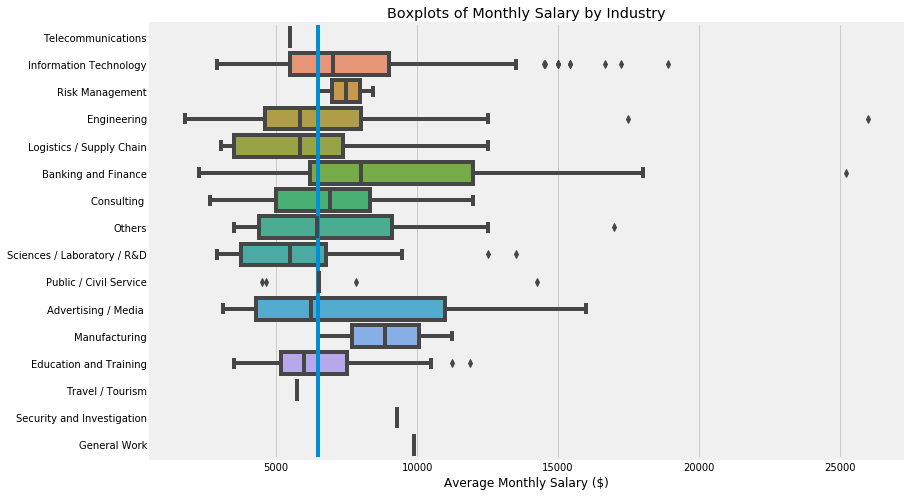

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df,y='jobindustry',x='avg_salary')
plt.ylabel('')
plt.xlabel('Average Monthly Salary ($)')
plt.title('Boxplots of Monthly Salary by Industry')
plt.axvline(x=6500)
plt.show()

# Median Salary is denoted by blue vertical line

### Seniority

In [19]:
df[df.seniority.isnull()]

,jobtitle,jobindustry,searchkeyword,responsibilities,requirements,skills_needed,employment,seniority,min_salary,max_salary,...,Industry__Information Technology,Industry__Logistics / Supply Chain,Industry__Manufacturing,Industry__Others,Industry__Public / Civil Service,Industry__Risk Management,Industry__Sciences / Laboratory / R&D,Industry__Security and Investigation,Industry__Telecommunications,Industry__Travel / Tourism
107,Office of Planning - Manager (Data Analyst / S...,Education and Training,data scientist,You will be part of a new Data Analytics (DA) ...,NaN,"['Management', 'Business Development', 'Strate...",Full Time,NaN,5700.0,6300.0,...,0,0,0,0,0,0,0,0,0,0
187,Senior Research & Development Project Engineer...,Education and Training,research scientist,"As a Senior R&D Project Engineer/Scientist, yo...",NaN,"['Matlab', 'Algorithms', 'C++', 'Machine Learn...",Full Time,NaN,3100.0,6199.0,...,0,0,0,0,0,0,0,0,0,0
640,Senior Manager / Manager (Compliance),Public / Civil Service,data analytics,Senior Manager / Manager¬† (Compliance)\nThe S...,NaN,"['Risk Management', 'Management', 'Leadership'...",Full Time,NaN,3000.0,6000.0,...,0,0,0,0,1,0,0,0,0,0
699,School of Management and Communication - Lectu...,Education and Training,data analytics,Job Responsibilities Facilitate student learni...,NaN,"['Research', 'Teaching', 'Lecturing', 'Higher ...",Full Time,NaN,3700.0,6300.0,...,0,0,0,0,0,0,0,0,0,0
700,School of Engineering - Assistant Manager / ...,Education and Training,data analytics,Job Responsibilities: Identify and develop bu...,NaN,"['Management', 'Project Management', 'Leadersh...",Full Time,NaN,4200.0,7300.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#impute missing seniority tags based on description

df.loc[107,'seniority'] = 'Manager'
df.loc[187.,'seniority'] = 'Senior Executive'
df.loc[640,'seniority'] = 'Manager'
df.loc[699,'seniority'] = 'Professional'
df.loc[700,'seniority'] = 'Manager'

In [21]:
# convert categorical column into numeric

df['seniority'] = df['seniority'].apply(lambda x : x.split(', '))
df_seniority = df['seniority']
df_seniority = pd.get_dummies(df_seniority.apply(pd.Series).stack()).sum(level=0)
df_seniority.columns = [x.lower() for x in df_seniority.columns]
# merge dataframes together
df = pd.concat([df,df_seniority],axis=1)

### Employment

In [22]:
df['employment'].value_counts()

Full Time                                    242
Permanent                                    168
Contract, Full Time                          118
Permanent, Full Time                          94
Contract                                      58
Permanent, Contract                           10
Permanent, Contract, Full Time                 4
Full Time, Internship                          3
Permanent, Temporary, Contract, Freelance      1
Internship                                     1
Temporary                                      1
Contract, Internship                           1
Name: employment, dtype: int64

In [23]:
# data cleaning of employment column and group into fewer categories

df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Full Time", 'Permanent') if x == "Full Time" else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Permanent, Full Time", 'Permanent') if x == 'Permanent, Full Time' else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Contract, Internship", 'Internship') if x == 'Contract, Internship' else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Full Time, Internship", 'Internship') if x == 'Full Time, Internship' else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Contract, Full Time", 'Contract') if x == 'Contract, Full Time' else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Temporary", 'Contract') if x == 'Temporary' else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Permanent, Contract, Full Time", 'Permanent, Contract') if x == 'Permanent, Contract, Full Time' else x)
df['employment'] = df['employment'].apply(lambda x: x.replace(
    "Permanent, Temporary, Contract, Freelance", 'Permanent, Contract')
    if x == 'Permanent, Temporary, Contract, Freelance' else x)

df['employment'].value_counts()

Permanent              504
Contract               177
Permanent, Contract     15
Internship               5
Name: employment, dtype: int64

In [24]:
# convert categorical column into numeric

df['employment'] = df['employment'].apply(lambda x : x.split(', '))
df_employment = df['employment']
df_employment = pd.get_dummies(df_employment.apply(pd.Series).stack()).sum(level=0)
df_employment.columns = [x.lower() for x in df_employment.columns]
# merge dataframes together
df = pd.concat([df,df_employment],axis=1)

### Job titles

In [25]:
# number of job titles containing data scientist

df['data_scientist'] = 0
for index in range(len(df)):
    #print(df.loc[index,'jobtitle'])
    jobtype = ['data scien', 'deep','nlp','machine','image','ml ','algorithm']
    for type in jobtype:
        if type in df.loc[index,'jobtitle'].lower():
            df.loc[index,'data_scientist'] = 1
    

In [26]:
df.data_scientist.value_counts()

0    555
1    146
Name: data_scientist, dtype: int64

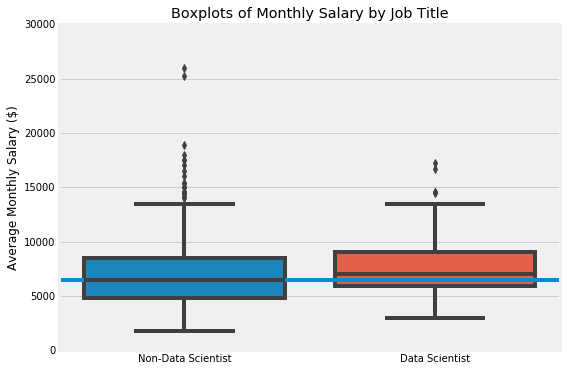

In [27]:
plt.figure(figsize=(8,6))
sns.boxplot(x='data_scientist',y='avg_salary',data=df)
plt.ylabel('Average Monthly Salary ($)')
plt.xticks(ticks=[0,1],labels=['Non-Data Scientist', 'Data Scientist'])
plt.xlabel('')
plt.ylim([0, 30000])
plt.title('Boxplots of Monthly Salary by Job Title')
plt.axhline(y=6500)
plt.show()

# Median average monthly salary denoted by blue line

The boxplot shows that the 50th percentile of a data scientist is slightly higher than the median average monthly salary of $6500.

In [28]:
# Hypothesis testing using one-tailed Ztest to test if mean salary of Data scientist is greater than $6500
# Ho: mean salary is equal to $6500
# H1: mean salary is greater than $6500

data1 = df[df['data_scientist']==0]['avg_salary']

from scipy import stats
from statsmodels.stats import weightstats as stests

ztest ,p = stests.ztest(data1, x2=None, value=6500)
print('%0.5f' % float(p))

0.00003


At p < 5%, reject Ho and conclude that the mean of the data scientist monthly salary is higher than the median average salary of $6500

### Skills needed

In [29]:
# convert categorical column into numeric
df['skills_needed'] = df['skills_needed'].apply(lambda x: x.replace(
    '[', '').replace(']', '').replace("'", "").split(', '))
df_skills_needed = df['skills_needed']
df_skills_needed = pd.get_dummies(
    df_skills_needed.apply(pd.Series).stack()).sum(level=0)
df_skills_needed.columns = [x.lower() for x in df_skills_needed.columns]
# merge dataframes together
df = pd.concat([df, df_skills_needed], axis=1)

### Requirements & Responsibilites

In [30]:
#some of missing requirements are with responsibilities column
df.requirements.fillna(value='',inplace=True)

In [31]:
# combine requirements and responsibilties and use NLP techniques to tokenize the words

df['space'] = '. '
temp_df = df['requirements'] + df['space'] + df['responsibilities']
df.drop(columns='space',inplace=True)

In [32]:
stopWords = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stopWords, ngram_range=(1,2),strip_accents='ascii',min_df=0.01,max_df=0.7)
Xv = vectorizer.fit_transform(temp_df)

df_compiled = pd.DataFrame(Xv.todense(), columns=vectorizer.get_feature_names())

df_model1 = pd.concat([df,df_compiled],axis=1)

# shape of df_model1 after vectorization
df_model1.shape

(701, 5141)

In [33]:
# Reduce the dimensions of the dataframe by summing the counts of columns with the same name

df_model1 = df_model1.groupby(level=0, axis=1).sum()
df_model1.shape

(701, 4950)

After data cleaning, left 701 out of the original 1081 jobs for model fitting.

### Data preparation for model fitting

In [34]:
X = df_model1.drop(columns=['jobtitle', 'searchkeyword', 'responsibilities','seniority', 'employment', 'jobindustry',
                     'requirements', 'skills_needed', 'min_salary', 'max_salary', 'avg_salary','salary_class'])
y = df['salary_class']

In [35]:
# Baseline
np.round(y.mean(),3)

# expected to be 0.5 as median salary was used as the threshold to determine high vs low monthly salary

0.499

In [36]:
# Train-test-split followed by StandardScaler to standardise data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rng, stratify=y)

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

### Model fitting

In [37]:
# Model fitting (Random Forest)

model = RandomForestClassifier(
    random_state=rng, n_estimators=5000, class_weight='balanced')

# use GridSearchCV to find best hyperparameter for the model
parameters = {'max_depth': [20, 22, 24]}
clf = GridSearchCV(model, parameters, cv=5, n_jobs=3, scoring='roc_auc')
clf.fit(Xs_train, y_train)

print('ROC AUC score: %0.2f' % roc_auc_score(
    y_test, clf.best_estimator_.predict(Xs_test)))

print(clf.best_params_)

# Sort coefficients of the model to identify important features
coefs_vars = pd.DataFrame({
    'coef': clf.best_estimator_.feature_importances_,
    'variable': X.columns
})
coefs_vars.sort_values('coef', ascending=False, inplace=True)
coefs_vars.head(10)

ROC AUC score: 0.72
{'max_depth': 22}


,coef,variable
4091,0.005812,solutions
3,0.004906,10 years
2,0.004646,10
4393,0.004400,team
2771,0.004328,microsoft office
1354,0.004181,drive
1873,0.004098,fresh/entry level
3399,0.003871,products
2478,0.003795,leading
2463,0.003787,latex


In [38]:
# Model fitting (Logistic Reqression)

model = LogisticRegression(random_state=rng, penalty='l1', max_iter=1000)

# use GridSearchCV to find best hyperparameter for the model
parameters = {'C': [0.05,0.1, 0.15, 0.2]}
clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(Xs_train, y_train)

print('ROC AUC score: %0.2f' % roc_auc_score(
    y_test, clf.best_estimator_.predict(Xs_test)))

print(clf.best_params_)

# Sort coefficients of the model to identify important features
coefs_vars = pd.DataFrame({
    'coef': clf.best_estimator_.coef_[0],
    'variable': X.columns,
    'abscoef': abs(clf.best_estimator_.coef_[0])
})
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars.head(10)

ROC AUC score: 0.74
{'C': 0.15}


,coef,variable,abscoef
1873,-0.445910,fresh/entry level,0.445910
3,0.338865,10 years,0.338865
3136,0.319752,pattern recognition,0.319752
1315,-0.309493,discipline,0.309493
616,-0.300828,c++,0.300828
2152,0.279267,implementing,0.279267
4091,0.233878,solutions,0.233878
3424,0.233420,programme,0.233420
1354,0.217813,drive,0.217813
4247,0.215291,strong communication,0.215291


### Summary

From the results above, the Logistic Regression model had a higher AUC_ROC_score of 0.74. Important features identified for a high salary job include seniority level, skills set (e.g. pattern recognition and implement solutions) and years of experience.

### Tradeoff Analysis

To determine the tradeoff between telling a client incorrectly that they would get a lower salary job versus telling a client incorrectly that they would get a high salary job by adjusting the model. Among the 2 models, Logistic Regression model had a higher auc_roc_score. Hence, it will be used for this part of the analysis.

In [39]:
# use the Logistic Regression Model
yhat = clf.best_estimator_.predict(Xs_test)
yhat_pp = clf.best_estimator_.predict_proba(Xs_test)

result = pd.DataFrame(yhat_pp,columns=['LowSalary','HighSalary'])
result['true'] = y_test.reset_index(drop=True)

# apply new threshold of 0.3
result['threshold_0.3'] = result['LowSalary'].apply(lambda x :  0 if x >=0.3 else 1)
result['threshold_0.5'] = result['LowSalary'].apply(lambda x :  0 if x >=0.5 else 1)

result.sample(5)

,LowSalary,HighSalary,true,threshold_0.3,threshold_0.5
20,0.960484,0.039516,0,0,0
1,0.953794,0.046206,0,0,0
111,0.488220,0.511780,1,0,1
91,0.350334,0.649666,0,0,1
64,0.524967,0.475033,0,0,0


In [40]:
# prints the confusion matrix for original and adjusted threshold 
# (i.e. threshold adjusted to 0.3, normally is 0.5)

confusion_orig = pd.crosstab(y_test,
                             yhat,
                             rownames=['Actual'],
                             colnames=['Predicted'],
                             margins=True)

confusion_adjusted = pd.crosstab(result['true'],
                                 result['threshold_0.3'],
                                 rownames=['Actual'],
                                 colnames=['Predicted'],
                                 margins=True)

print('------Original Threshold------')
print(confusion_orig/len(y_test)*100)
print('')
print('------Adjusted Threshold------')
print(confusion_adjusted/len(y_test)*100)

------Original Threshold------
Predicted          0          1        All
Actual                                    
0          39.716312  10.638298   50.35461
1          14.893617  34.751773   49.64539
All        54.609929  45.390071  100.00000

------Adjusted Threshold------
Predicted          0          1        All
Actual                                    
0          46.099291   4.255319   50.35461
1          27.659574  21.985816   49.64539
All        73.758865  26.241135  100.00000


To lower the chance of incorrectly telling a client that they would get a high salary job, the threshold is lowered to 30%. As a result, the probability of incorrectly telling a client that they would get a high job is lowered from 10.6% to 4.3% (reduction of 6.3%). However, the tradeoff is that probability of incorrectly telling a client that they will get a low salary job is increased from 14.9% to 27.7% (increase of 12.8%).

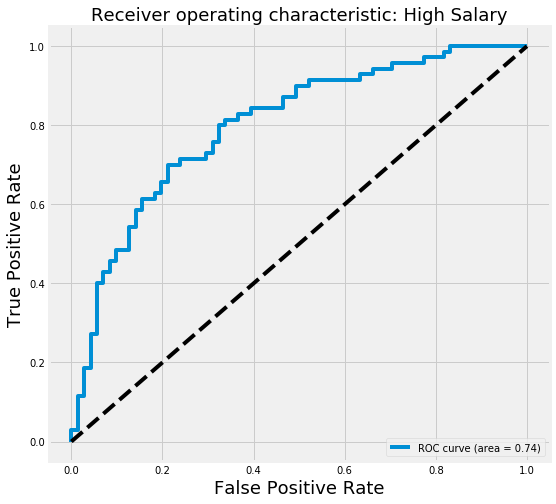

In [41]:
# Plot ROC curve

fpr, tpr, _ = roc_curve(y_test, yhat_pp[:,1])
roc_auc = roc_auc_score(y_test,yhat)

plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: High Salary', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Section 2: Factors that distinguish a data scientist job title from other titles

### Data preparation for model fitting

In [42]:
# remove additional stop word of scientist, otherwise it will 
# appear as important factor

stopWords = stopwords.words('english') + ['scientist']

vectorizer = CountVectorizer(stop_words=stopWords, ngram_range=(
    1, 2), strip_accents='ascii', min_df=0.003)
Xv = vectorizer.fit_transform(temp_df)

df_compiled = pd.DataFrame(
    Xv.todense(), columns=vectorizer.get_feature_names())

df_model2 = pd.concat([df, df_compiled], axis=1)

# shape of df after vectorization
print(df_model2.shape)

X = df_model2.drop(columns=['jobtitle', 'searchkeyword', 'responsibilities',
                            'seniority', 'employment', 'jobindustry',
                            'requirements', 'skills_needed', 'min_salary',
                            'max_salary', 'avg_salary', 'salary_class', 'data_scientist'])
y = df['data_scientist']

(701, 16260)


In [43]:
# Baseline, imbalanced dataset observed
np.round(y.mean(),2)

0.21

### Model fitting

In [44]:
# train-test-split

X_train_model2, X_test_model2, y_train_model2, y_test_model2 = train_test_split(
    X, y, test_size=0.2, random_state=rng, stratify=y)

skf = StratifiedKFold(n_splits=5)

In [45]:
# Model fitting (Logistic Regression)

for C_value in [0.1,0.15,0.2]:
    roc_auc_list = []

    for train_index, test_index in skf.split(X_train_model2, y_train_model2):
        X_train, X_test = X_train_model2.iloc[train_index,
                                              :], X_train_model2.iloc[test_index, :]
        y_train, y_test = y_train_model2.iloc[train_index], y_train_model2.iloc[test_index]

        # prepare data to do resampling
        df_combined = pd.concat([y_train, X_train], axis=1)
        df_combined.rename(columns={0: 'data_scientist'}, inplace=True)

        # Separate majority and minority classes
        df_majority = df_combined[df_combined['data_scientist'] == 0]
        df_minority = df_combined[df_combined['data_scientist'] == 1]

        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,     # sample with replacement
                                         # to match majority class
                                         n_samples=len(df_majority),
                                         random_state=123)  # reproducible results

        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])

        # split to get the new resampled target and predictors
        X_train = df_resampled.drop(columns='data_scientist')
        y_train = df_resampled['data_scientist']

        Xs_train = ss.fit_transform(X_train)
        Xs_test = ss.transform(X_test)

        model = LogisticRegression(
            C=C_value, random_state=rng, max_iter=1000, penalty='l1', n_jobs=-1)

        model.fit(Xs_train, y_train)
        y_pred = model.predict(Xs_test)
        roc_auc_list.append(roc_auc_score(y_test, y_pred))

    print('C: ', np.round(C_value,2))
    print('Mean ROC AUC score: %0.2f' % np.mean(roc_auc_list))
    #print('Raw: ', roc_auc_list)

C:  0.1
Mean ROC AUC score: 0.77
C:  0.15
Mean ROC AUC score: 0.77
C:  0.2
Mean ROC AUC score: 0.76


In [46]:
# Use best hyperparameter to fit Logistic Regression model
model = LogisticRegression(
            C=0.15, random_state=rng, max_iter=1000, penalty='l1')
model.fit(X_train_model2,y_train_model2)

print('ROC AUC score: %0.2f' % roc_auc_score(y_test_model2,model.predict(X_test_model2)))

# Sort coefficients of the model to identify important features
coefs_vars = pd.DataFrame({
        'coef':model.coef_[0],
        'variable':X.columns,
        'abscoef':abs(model.coef_[0])
    })
coefs_vars.sort_values('abscoef', ascending=False, inplace=True)
coefs_vars.head(10)

ROC AUC score: 0.72


,coef,variable,abscoef
600,-0.642792,teaching,0.642792
4126,0.532530,data science,0.532530
14246,-0.393596,system,0.393596
1282,0.332415,algorithms,0.332415
12247,-0.267142,research,0.267142
8409,0.265024,learning,0.265024
1474,0.248157,analytic,0.248157
4317,-0.243265,degree,0.243265
9379,0.243073,mining,0.243073
4687,-0.227360,development,0.227360


In [47]:
# Model fitting (Random Forest)

for depth_value in [15, 20, 25]:
    roc_auc_list = []

    for train_index, test_index in skf.split(X_train_model2, y_train_model2):
        X_train, X_test = X_train_model2.iloc[train_index,
                                              :], X_train_model2.iloc[test_index, :]
        y_train, y_test = y_train_model2.iloc[train_index], y_train_model2.iloc[test_index]

        # prepare data to do resampling
        df_combined = pd.concat([y_train, X_train], axis=1)
        df_combined.rename(columns={0: 'data_scientist'}, inplace=True)

        # Separate majority and minority classes
        df_majority = df_combined[df_combined['data_scientist'] == 0]
        df_minority = df_combined[df_combined['data_scientist'] == 1]

        # Upsample minority class
        df_minority_upsampled = resample(df_minority,
                                         replace=True,     # sample with replacement
                                         # to match majority class
                                         n_samples=len(df_majority),
                                         random_state=123)  # reproducible results

        # Combine majority class with upsampled minority class
        df_resampled = pd.concat([df_majority, df_minority_upsampled])

        # split to get the new resampled target and predictors
        X_train = df_resampled.drop(columns='data_scientist')
        y_train = df_resampled['data_scientist']

        Xs_train = ss.fit_transform(X_train)
        Xs_test = ss.transform(X_test)

        model = RandomForestClassifier(max_depth=depth_value, random_state=rng,
                                       n_estimators=5000, class_weight='balanced', n_jobs=-1)

        model.fit(Xs_train, y_train)
        y_pred = model.predict(Xs_test)
        roc_auc_list.append(roc_auc_score(y_test, y_pred))

    print('Max_depth: ', depth_value)
    print('Mean ROC AUC score:  %0.2f' % np.mean(roc_auc_list))
    #print('Raw: ', roc_auc_list)

Max_depth:  15
Mean ROC AUC score:  0.75
Max_depth:  20
Mean ROC AUC score:  0.73
Max_depth:  25
Mean ROC AUC score:  0.73


In [48]:
# Use best hyperparameter to fit Random Forest model
model = RandomForestClassifier(max_depth=15, random_state=rng,
                                       n_estimators=5000, class_weight='balanced', n_jobs=-1)
model.fit(X_train_model2,y_train_model2)
print('ROC AUC score: %0.2f' % roc_auc_score(y_test_model2,model.predict(X_test_model2), average='weighted'))

# Sort coefficients of the model to identify important features
coefs_vars = pd.DataFrame({
        'coef':model.feature_importances_,
        'variable':X.columns
    })
coefs_vars.sort_values('coef', ascending=False, inplace=True)
coefs_vars.head(10)

ROC AUC score: 0.70


,coef,variable
8409,0.012486,learning
8787,0.012155,machine learning
8785,0.011804,machine
11677,0.010460,python
4126,0.009743,data science
1282,0.007770,algorithms
3962,0.007199,data
12736,0.006939,science
8891,0.006745,management
9462,0.005432,models


### Summary

From the results above, the Logistic Regression model has the higher ROC_AUC_score of 0.72. Important factors identified to distinguish between data scientist title and other titles include data science, deep/machine learning and algorithms.